<a href="https://colab.research.google.com/github/IoPapadopoulos/Hmumu_analysis/blob/main/Hmumu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How to search for the rare decay of a Higgs boson to Muon-Antimuon Pair ($H \rightarrow \mu^+ \mu^-$) Yourself!**

This notebook utilizes ATLAS Open Data to guide you through the steps necessary to search for the rare decay of a Higgs boson into a muon-antimuon pair ($H \rightarrow \mu^+ \mu^-$) produced by high-energy proton-proton collisions at the Large Hadron Collider (LHC).

ATLAS Open Data provides open access to proton-proton collision data recorded by the ATLAS experiment at the LHC. This dataset is available for educational purposes, making it ideal for students and educators at various levels who are interested in particle physics and various types of data analyses.


# **What Are Notebooks?**

Notebooks are interactive web applications that allow you to create and share documents that contain:

1. **Live code:** Write and execute code in real-time, making adjustments as you go.

2. **Visualizations:** Create plots, histograms, and other graphical representations of your data to better understand the underlying physics.

3. **Narrative text:** Include explanations, descriptions, and commentary to guide yourself or others through the analysis.


# **The Goal: Hunt for the decay H $\rightarrow \mu^+ \mu^-$**
This notebook will walk you through the process of possibly identifying and studying the decay of the Higgs boson into two muons ($ a\ muon\ and\ an\ anti-muon\ \mu^+ \mu^-$). This decay channel is extremely rare, but it provides an essential probe of the interactions between the Higgs boson and second-generation fermions (leptons in this case) and muons in particular, since they are the heaviest second generation ones.

By following this notebook, you will perform a $H \rightarrow \mu^+ \mu^-$ search. You will apply a sequence of event selection criteria (cuts) to maximize the signal (events where $H \rightarrow \mu^+ \mu^-$) to background (other processes producing pairs of muons) ratio.

The process involves identifying two high-energy muons in the final state and reconstructing their invariant mass to look for a peak/bump around the Higgs boson mass of 125 GeV. The signal signature can be described as:

$pp \rightarrow H \rightarrow \mu^+ \mu^-$,
where:

$\mu^+$ is a positively charged muon(called anti-muon),
$\mu^-$ is a negatively charged muon.



**Contents:**  
* Running a Jupyter notebook
* To setup
* Explanation of Key Parameters in the $H \rightarrow \mu^+ \mu^-$ Analysis Code
* Samples
* Weight in Particle Physics Analysis
* Introduction to Event Selection Cuts in $H \rightarrow \mu^+ \mu^-$ Analysis
* Introduction to Mass Reconstruction in $H \rightarrow \mu^+ \mu^-$ Analysis
* Data Processing and Event Selection Function
* Data Retrieval in $H \rightarrow \mu^+ \mu^-$ Analysis
* Data Processing
* Data Aggregation with Loops
* Plotting

# **Running a Jupyter notebook**
To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.



# **ATLAS Open Data Initialisation**
**First time package installation on your computer**

This first cell installs the required python packages. It only needs to be run the first time you open this notebook on your computer. If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

In [ ]:
!pip install atlasopenmagic
!pip install uproot

# **To setup**
Cell -> Run All Below

to be done every time you re-open this notebook  !!!!!!!!

We're going to be using a number of tools to help us:

* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us use efficiently the nested data in columnar format
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [ ]:
import uproot # For reading ROOT files efficiently
import awkward as ak # To represent nested data in columnar format
import pandas as pd # For dataframes, a format widely used in python
import numpy as np # For numerical calculations such as histogramming
import time # For timing operations and adding delays if needed
import matplotlib.pyplot as plt # For creating plots and visualizations
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import atlasopenmagic as atom  # Provides access to ATLAS Open Data metadata and streaming URLs
from concurrent.futures import ProcessPoolExecutor, as_completed # Enables parallel execution for faster processing of large datasets
# Filter warnings that otherwise appear in output. These are normal in the running of this notebook.
import warnings

warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="overflow encountered in power")
warnings.filterwarnings("ignore", message="overflow encountered in multiply", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")

# **Explanation of Key Parameters in the $H \rightarrow \mu^+ \mu^-$ Analysis Code**
In particle physics, various parameters are crucial for correctly analyzing data and obtaining meaningful results. Below is an explanation of the key parameters used in the  $H \rightarrow \mu^+ \mu^-$ analysis code:


1. **Integrated Luminosity (lumi) Definition**
  *   The integrated luminosity is a measure of the total data collected by the detector over a specific period. It is essential for determining the number of expected signal and background events in an analysis and is typically expressed in inverse femtobarns (fb$^{-1}$) or inverse picobarns (pb$^{-1}$). Higher luminosity means a larger statistical dataset to hunt for the rare processes like  $H \rightarrow \mu^+ \mu^-$.
2. **Fraction of Events to Process**
  *   Definition: This parameter specifies the fraction of the total dataset to be processed by the analysis code. Reducing the fraction can be useful for testing or optimizing the analysis without processing the full dataset, saving computational time.

3. For further information visit [atlas glossary](https://atlas.cern/glossary)





In [ ]:
# Integrated luminosity in inverse picobarns
lumi = 36000.

# Fraction of events to process
fraction = 0.01

# **Samples**
We select these samples below to capture both the signal and relevant background processes for the Higgs boson decay to muon pairs ($H \rightarrow \mu^+ \mu^-$). The data samples include all possible processes that produce a pair of muon-antinuon.  The background samples consist of simulated events chosen to account for the primary sources of noise in the analysis: the continuum Drell-Yan $\mu^+ \mu^-$production, which closely mimics the signal, and smaller contributions from $t\bar{t}$ production processes. Including these samples allows us to model the background accurately and optimize cuts to enhance the signal-to-background ratio.

Notice that we are using a 2 muon skim. Events have been pre-selected to include two good muons to reduce the total amount of data that must be processed



In [ ]:
atom.set_release('2025e-13tev-beta')

mc_defs = {
    r'ttbar':    {'dids': [410470],},
    r'mu_mu': {'dids': [700323,700324,700325]},
    r'Higgs':  {'dids': [345106,345098,345097]},
}

mc_samples   = atom.build_mc_dataset(mc_defs,   skim='2muons', protocol='https')
data_samples_1 = atom.build_data_dataset('2muons', name="Data", protocol='https')

samples = {**data_samples_1, **mc_samples}

variables = ["mcWeight", "ScaleFactor_LepTRIGGER", "trigE", "trigM", "lep_n", "lep_pt","ScaleFactor_BTAG","lep_isMediumID",
            "lep_eta", "lep_phi", "lep_charge", "lep_type", "met", "met_phi", "sum_of_weights", "ScaleFactor_FTAG","lep_isLooseIso",
            "xsec", "jet_pt", "jet_btag_quantile", "jet_n", "jet_eta", "jet_phi", "jet_e","jet_jvt","lep_isTrigMatched",
            "lep_type", "lep_e", "eventNumber", "ScaleFactor_ELE", "ScaleFactor_MUON","ScaleFactor_PILEUP","filteff", "kfac"]

# **Weight in Particle Physics Analysis**

In particle physics analysis, such as in the study of the production of Higgs boson, the concept of "weight" plays a crucial role. Weights are factors applied to events or data points in a dataset to ensure that the results of an analysis accurately reflect the underlying physics being studied. These weights account for various factors, including the efficiencies of detectors, the probability of certain processes occurring, and the corrections needed to match the simulated data with real data from the LHC running.

The following function computes the event weights by combining several correction factors, including trigger efficiencies, pileup corrections, b-tagging efficiencies, and cross-sections. The result is a set of weights that accurately reflect the likelihood and significance of each event, ensuring that the final analysis properly accounts for all relevant physical and experimental considerations.

In [ ]:
def calc_weight(data):
    weight_list =( data["ScaleFactor_MUON"] * data["ScaleFactor_LepTRIGGER"] * data["ScaleFactor_PILEUP"] *
             ( data["ScaleFactor_BTAG"] * data["mcWeight"] / data["sum_of_weights"]) * (data["xsec"] * data["filteff"] * data["kfac"] * lumi) )
    return weight_list

# **Introduction to Event Selection Cuts in $H \rightarrow \mu^+ \mu^-$ Analysis**
In particle physics, event selection cuts are essential to isolate signal events from overwhelming background processes. For the analysis of the Higgs boson decay into muon pairs ($H \rightarrow \mu^+ \mu^-$), these cuts help filter out events that are unlikely to be associated with this rare decay mode, enhancing the likelihood of observing a signal. By applying specific selection criteria based on the physical properties of the final-state particles, we can enrich the dataset with potential signal events.
The following are key event selection cuts used in the $H \rightarrow \mu^+ \mu^-$ analysis, result from studies, aiming to maximize the signal-to-background ratio:


1. **Trigger Selection:**
  *   The first step in the analysis is to ensure that the events under consideration have fired the appropriate muon trigger (trigM).

  *   Purpose: This cut checks whether the muon trigger has been activated for an event. If the muon trigger fired, the event is considered for further analysis, ensuring that only relevant events with potential muon candidates are processed.




In [ ]:
def cut_trig(trigM):
    return trigM

  2. **Matched Cut:**

   *    This cut ensures that the event contains at least one lepton that is matched with a trigger.

   *     Purpose: The cut ensures that at least one lepton in the event is associated with a trigger, meaning it was responsible for the event being recorded. Applying this cut reduces backgrounds from events where no lepton is properly matched to a trigger, improving the selection efficiency for signal events.

In [ ]:
def Matched_cut(Matched):
    return ak.sum(Matched == True, axis=1) >= 1

  3. **Dilepton Selection:**

    *   This cut ensures that the event contains exactly two leptons, which is essential for isolating signal events involving a muon pair.

    *   Purpose: The cut checks if the number of leptons in the event (lep_n) is exactly equal to 2. Events with two leptons are selected for further analysis, as this is a signature of the
$H \rightarrow \mu^+ \mu^-$ decay, where the Higgs boson decays into a pair of muons. Events with fewer or more leptons are rejected to reduce background events.

In [ ]:
def two_lep(lep_n):
    return lep_n == 2

4. **Lepton Transverse Momentum ($p_T$) Cut:**
  * This cut ensures that both leptons in the event have sufficiently high transverse momentum ($p_T$), a key signature of particles originating from a Higgs boson decay.

  * Purpose:  This cut checks if at least two leptons in the event have $p_T$ values greater than the set threshold (pt_lim = 30 GeV). Selecting leptons with high $p_T$ helps suppress background events where low-energy leptons may come from processes other than the signal. Only events with two leptons that pass the $p_T$ threshold are kept for further analysis.

In [ ]:
def cut_lep_pt(lep_pt):
    return ak.sum(lep_pt > 30, axis=1) >= 2

5. **Missing Transverse Energy ($E_T^{miss}$) Cut:**
  * This cut ensures that the missing transverse energy ($E_T^{miss}$) in the event is below a specific threshold, helping to distinguish signal events from background processes with high missing energy.

   * Purpose: This cut checks if $E_T^{miss}$ is less than or equal to 80 GeV. In $H \rightarrow \mu^+ \mu^-$ events, there is typically little missing energy, since the muons carry most of the momentum. Background processes involving neutrinos or other undetected particles often result in higher missing energy. By applying this cut, we reduce contamination from such background events, enhancing the purity of the selected signal events.

  

In [ ]:
def cut_met_et(met_et):
    return met_et <= 80

6. **Opposite Charge Cut:**
  * This cut ensures that the two leptons in the event have opposite charges.

  * Purpose: The cut checks if the sum of the charges of the two leptons is zero, meaning one lepton has a positive charge and the other has a negative charge. This is consistent with the $H \rightarrow \mu^+ \mu^-$ signal, where the Higgs decays into a positively charged anti-muon ($\mu^+$) and a negatively charged muon ($\mu^-$).This is a direct consequence of charge conservation, since the Higgs boson is neutral. Events where the lepton pair does not have opposite charges are rejected.

In [ ]:
def cut_charge(charge):
    return ak.sum(charge, axis=1) == 0

7. **Lepton Type Cut:**
  * This cut ensures that both leptons in the event are muons, which is essential for isolating the signal from the Higgs boson decay into muon pairs.

  * Purpose: The cut checks if both leptons in the event are identified as muons by verifying that their type is equal to 13. The condition ensures that exactly two muons are present in the event, which is the sought after decay mode.Events containing leptons that are not muons are rejected.

In [ ]:
def cut_type(type1):
    return ak.sum(type1 == 13, axis=1) == 2

8. **Identification (ID) and Isolation (Iso) Cut:**
  * This cut is designed to ensure that events selected contain particles (such as muons) that pass both identification (ID) and isolation (Iso) criteria, which are essential for selecting well-reconstructed and isolated particles.

  * Purpose:

    * In particle physics analyses, particularly in Higgs boson decays like
  $H \rightarrow \mu^+ \mu^-$, it is crucial to apply selection criteria based on particle identification and isolation. Identification ensures that the particles detected correspond to the expected particle type (e.g., muons), and isolation ensures that the particles are not part of a jet of particles.

  * The cut performs two checks:

    * Identification (ID) Check:
  The function checks whether the total number of particles that pass the identification criteria in each event is greater than one. This ensures that the event contains at least two well-identified muons.
    * Isolation (Iso) Check:
  Similarly, the function checks whether the number of particles passing the isolation criteria is greater than one for each event. This ensures that multiple particles in the event are well-isolated. Non-isolated muons could be non-prompt ones coming from hadronic decays.

In [ ]:
def ID_iso_cut(ID,iso):
    return ak.sum(ID & iso,axis=1) > 1

9. **Jet Selection Cut:**
  * This selection cut ensures that the event contains at least two jets that satisfy specific criteria for energy, transverse momentum, and b-tagging. The two jets come from the production of the Higgs boson, normally in the Vector Boson Fusion mechanism, which is one of the dominant production mechanisms. The gluon-gluon fusion (ggF) production mechanism is more common, but can be harder to distinguish from the background because of its relatively lower jet activity.

  * Purpose: The cut performs three checks:

    1. **Energy Check:** Confirms that the event has at least two jets with an energy of 30 GeV or higher.
    2. **Transverse Momentum Check:** Verifies that at least two jets have transverse momentum values exceeding 30 GeV or higher.
    3. **b-Tagging Check:**
      Ensures that at least two jets have b-tagging scores less than or equal to 3. Lower b-tagging scores indicate a higher probability of the jet contains b-quarks from decays of top quarks, which could contain non-prompt background muons (e.g. muons from hadron decays, rather than from Higgs bosons).

    By applying this cut, we focus on events with significant jet activity, which is often associated with the production of the Higgs boson in high-energy proton-proton collisions. Events that do not meet all these criteria are rejected, thereby enhancing the likelihood of selecting signal events while suppressing background noise from processes with fewer or lower-energy jets.


In [ ]:
def cut_jet(E,pt,b_jet):
    return ak.sum((E >= 30) & (pt >= 30) & (b_jet <= 3), axis=1) >=2

10. **Delta R ($\Delta R$) Cut:**
  * This cut ensures that the jets in the event are sufficiently separated from the muons in the $\eta-\phi$ space, which helps to reduce contamination from misidentified events.

  * Purpose: The cut calculates the $\Delta R$ values for each jet with respect to both muons using their pseudorapidities ($\eta$) and azimuthal angles ($\phi$):

    * Calculating $\Delta R$ for Each Muon:
      $\Delta R_{M1}$ is computed between each jet and the first muon.
      $\Delta R_{M2}$ is computed between each jet and the second muon.
    * Separation Criteria: The cut checks if at least one jet is separated from each muon by $\Delta R \geq 0.4$. This separation is crucial to ensure that the jets are not too close to the muons, which could indicate that the muons are not originating from the Higgs decay but rather from other background processes.

In [ ]:
def cut_DR(eta,phi,eta_M,phi_M):

    Dphi1 = np.arcsin( np.sin(phi -  phi_M[:,0]) )
    Dphi2 = np.arcsin( np.sin(phi -  phi_M[:,1]) )

    Deta1 = eta - eta_M[:,0]
    Deta2 = eta - eta_M[:,1]

    DR_M1 = np.sqrt((Deta1)**2 + (Dphi1)**2)
    DR_M2 = np.sqrt((Deta2)**2 + (Dphi2)**2)

    DR_M1_check = ak.sum(DR_M1 >= 0.4, axis=1) >= 1
    DR_M2_check = ak.sum(DR_M2 >= 0.4, axis=1) >= 1

    return (DR_M1_check) & (DR_M2_check)

11. **Vector Boson Fusion (VBF) Cut:**

* This cut identifies events consistent with the Vector Boson Fusion (VBF) production mechanism, where two high-energy jets are produced in association with the Higgs boson.

* Purpose: The cut performs two primary checks to ensure that the event characteristics are consistent with VBF production:

    1. Invariant Mass Check:

  * The invariant mass of each pair of jets is calculated using their energy ($E$), transverse momentum ($p_T$), and pseudorapidity ($\eta$) values. The invariant mass is derived from the four-momentum of the jets.

  * The cut checks if at least one jet pair has an invariant mass greater than or equal to 500 GeV. This threshold is significant because it indicates the presence of high-energy jets in the forward direction typical in VBF processes.

  2. Pseudorapidity Separation Check:
  * The cut also assesses the separation in pseudorapidity between jet pairs. Specifically, it checks if the absolute difference in $\eta$ between at least one pair of jets is greater than 3, indicating they are well-separated in rapidity.
  * Additionally, it ensures that at least one pair of jets has one jet with a positive $\eta$ and the other with a negative $\eta$, confirming the jets are produced in opposite directions.

* Alternate Selection Option: Consider relaxing the VBF cuts (e.g. lowering the invariant mass) or switching to a ggF-based selection. ggF normally does not have significant jet activity, so one can try a jet veto instead.

In [ ]:
def cut_VBF(jet_E,pt,eta,phi):
    jet_px = pt * np.cos(phi)
    jet_py = pt * np.sin(phi)
    jet_pz = pt / np.tan(2.0 * np.arctan( np.exp( -eta ) ) )

    # Helper function to create combinations of jets
    def combo(list_1):
        jets_pairs = ak.combinations(list_1, 2, fields=['List1', 'List2'])
        sum_List = jets_pairs['List1'] + jets_pairs['List2']
        return sum_List

    combo_jet_E = combo(jet_E)
    combo_jet_px = combo(jet_px)
    combo_jet_py = combo(jet_py)
    combo_jet_pz = combo(jet_pz)

    Mass = np.sqrt(combo_jet_E**2 -(combo_jet_px**2 + combo_jet_py**2 + combo_jet_pz**2))

    jets_pairs = ak.combinations(eta, 2, fields=['List1', 'List2'])
    abs_dif_eta = np.abs(jets_pairs['List1'] - jets_pairs['List2'])
    eta_mult = jets_pairs['List1'] * jets_pairs['List2']

    return ak.sum((abs_dif_eta > 3) & (eta_mult < 0) & (Mass>=500), axis=1) > 0

# **Introduction to Mass Reconstruction in $H \rightarrow \mu^+ \mu^-$ Analysis**
In the analysis of Higgs boson decays into muon pairs ($H \rightarrow \mu^+ \mu^-$), accurately reconstructing the mass of the Higgs boson is essential for identifying the signal and distinguishing it from various background processes. The Higgs boson, a fundamental particle responsible for giving mass to other particles, has a relatively narrow mass range centered around 125 GeV. Therefore, precise mass reconstruction is critical for effective Higgs searches.

The mass reconstruction process involves using the kinematic information of the detected muons, to derive the invariant mass of the Higgs boson. This requires careful consideration of the momentum, energy, and spatial distributions of the muons and other particles produced in the collision.

The following steps outline the mass reconstruction procedure for the $H \rightarrow \mu^+ \mu^-$ decay channel:

* **Purpose:** The leptonic Higgs mass is reconstructed using the two muons produced from the Higgs decay.


* **Invariant Mass Calculation:** Use the four-momenta of the two muons to $$m_{μ^+μ^-}= \sqrt{(E_{\mu^+}+ E_{\mu^-})^2 - (\vec{p}_{\mu^+} + \vec{p}_{\mu^-})^2}$$


In [ ]:
def Hmass(E,pt,eta,phi):
    lep_E = ak.sum(E, axis=1)
    lep_px = ak.sum(pt * np.cos(phi), axis=1)
    lep_py = ak.sum(pt * np.sin(phi), axis=1)
    lep_pz = ak.sum(pt / np.tan(2.0 * np.arctan( np.exp( -eta ) ) ), axis=1)
    Mass = np.sqrt(lep_E**2 -(lep_px**2 + lep_py**2 + lep_pz**2))
    return Mass

# **Event Processing Function**

The process_file function processes ROOT files by:

1. **Loading data**: Opens the TTree and reads specified variables in chunks
2. **Applying selection cuts**: Implements a sequential series of cuts
3. **Computing derived quantities**: Calculates invariant mass and event weights

The function processes data in chunks to manage memory efficiently and returns a flattened array of all events that pass the selection criteria.

In [ ]:
def process_file(file_path, sample_name,loop):
    # Open the 'analysis' TTree from the ROOT file
    tree = uproot.open(file_path + ":analysis")
    sample_data = []

    for data in tree.iterate(variables, library="ak", entry_start=int(tree.num_entries * fraction * loop),
                             entry_stop=int(tree.num_entries * fraction * (loop+1))):

            data = data[cut_trig(data.trigM)]
            data = data[Matched_cut(data.lep_isTrigMatched)]
            data = data[two_lep(data.lep_n)]
            data = data[cut_met_et(data.met)]
            data = data[cut_type(data.lep_type)]
            data = data[cut_lep_pt(data.lep_pt)]
            data = data[cut_charge(data.lep_charge)]
            data = data[ID_iso_cut(data.lep_isMediumID, data.lep_isLooseIso)]
            data = data[cut_jet(data.jet_e, data.jet_pt, data.jet_btag_quantile)]
            data = data[cut_DR(data.jet_eta, data.jet_phi, data.lep_eta, data.lep_phi)]
            data = data[cut_VBF(data.jet_e, data.jet_pt, data.jet_eta, data.jet_phi)]


            data['Inv_mass'] = Hmass(data.lep_e, data.lep_pt, data.lep_eta, data.lep_phi)

            if 'data' not in sample_name:
                data['Weight'] = calc_weight(data)
            else:
                data['Weight'] = ak.ones_like(data['met'])

            sample_data.append(data)

    # Concatenate all data from the current file into a single array
    return ak.concatenate(sample_data, axis=0)

# **Parallel Analysis Function**

The parallel_analysis function processes a file in parallel using multiple processes to analyze data for a given sample. It submits four tasks to process the file using the ProcessPoolExecutor. Each task calls the process_file function. The results from successful tasks are collected and combined into a single Awkward Array.

In [ ]:
def parallel_analysis(file_path, sample_name):
    # Parallel processing
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(process_file, file_path, sample_name, 0),
                  executor.submit(process_file, file_path, sample_name, 1),
                  executor.submit(process_file, file_path, sample_name, 2),
                  executor.submit(process_file, file_path, sample_name, 3)}

        results = []
        for future in as_completed(futures):
            try:
                results.append(future.result())
            except Exception as e:
                continue
                print(f"Error in {data_type} loop {futures[future]}: {e}")

    # Combine results into an Awkward Array
    combined_array = ak.concatenate(results, axis=0) if results else ak.Array([])

    return combined_array

# **Main Analysis Loop**

This code initiates the full analysis by iterating over all data and MC samples defined in the `samples` dictionary. For each sample, it processes the associated ROOT files using the `parallel_analysis` function and stores the resulting data in the `data_all` dictionary. The processed outputs are combined into a single Awkward Array per sample.


In [ ]:
start_all = time.time()  # Define start time
data_all = {}  # Dictionary to store results for each sample
fraction = 0.25 # Lower this vaule for less running time
print("The analysis has started")

for s in samples:
    frames = []
    print("processing the ",s," samples")

    # Loop over ROOT files associated with the current sample
    for val in samples[s]['list']:

        DF = parallel_analysis(val, s)
        frames.append(DF) # Collect the results

    # Store the frames for this sample
    data_all[s] = ak.concatenate(frames, axis=0)

end_all = time.time()
print(f"\nTotal time taken to process all samples: {round((end_all - start_all) / 60, 1)} minutes")

The analysis has started
processing the  Data  samples
processing the  ttbar  samples
processing the  mu_mu  samples
processing the  Higgs  samples

Total time taken to process all samples: 27.7 minutes


# **Plotting**




In [ ]:
def plot_data(data,fit):

    # Define plot parameters
    xmin, xmax, step_size = 110, 160, 2

    # Define MC data sets and their properties
    datasets = [
        {'data': data['ttbar']['Inv_mass'], 'weights': data['ttbar']['Weight'], 'color': 'cyan', 'label': r'$t\bar{t}$'},
        {'data': data['mu_mu']['Inv_mass'], 'weights': data['mu_mu']['Weight'], 'color': 'orange', 'label': r'$μ^{-}μ^{+}$'}]

    # Create bin edges and centers
    bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_centres = np.arange(xmin + step_size/2, xmax + step_size/2, step_size)

    # Compute the histogram of the data
    data_x, _ = np.histogram(data['Data']['Inv_mass'], bins=bin_edges)

    data_x_errors = np.sqrt(data_x)  # statistical error on the data

    # Create main plot and residual subplot
    fig, (main_axes, residual_axes) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Plot data with error bars
    Cut1 = (bin_centres >= xmin) & (bin_centres <= xmax)  # Cut for main plotting range
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label=f'Data entries = {sum(data_x[Cut1])}')

    # Plot the Monte Carlo bars
    mc_heights = main_axes.hist([d['data'] for d in datasets], bins=bin_edges, weights=[d['weights'] for d in datasets],
                                stacked=True,color=[d['color'] for d in datasets], label=[d['label'] for d in datasets])

    mc_x_tot = (mc_heights[0][1])  # Stacked background MC y-axis value

    # Calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack([d['data'] for d in datasets]), bins=bin_edges,weights=np.hstack([d['weights'] for d in datasets])**2)[0])

    # Plot the statistical uncertainty
    main_axes.bar(bin_centres, 2*mc_x_err, alpha=0.5, bottom=mc_x_tot-mc_x_err,color='none', hatch="////", width=step_size, label='Stat. Unc.')

    # Set up main axes
    main_axes.set_xlim(left=xmin, right=xmax)

    if fit == True:
        higgs_hist, _ = np.histogram(data['Higgs']['Inv_mass'], bins=bin_edges, weights=data['Higgs']['Weight']*100)
        main_axes.step(bin_centres, higgs_hist, where='mid', color='purple', linewidth=3, label='Higgs *100')

    # Add headspace to the plot
    ymax = max(np.max(data_x), np.max(np.sum(mc_heights[0], axis=0)))
    main_axes.set_ylim(0, ymax * 1.4)  # Add 40% headspace
    main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    main_axes.tick_params(which='both', direction='in', top=True, right=True)
    main_axes.set_ylabel('Events', y=1, horizontalalignment='right')
    main_axes.yaxis.set_minor_locator(AutoMinorLocator())

    # Add text to the plot
    main_axes.text(0.05, 0.93, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13)
    main_axes.text(0.05, 0.88, 'for education', transform=main_axes.transAxes, style='italic', fontsize=8)
    main_axes.text(0.05, 0.82, r'$\sqrt{s}$=13 TeV, 36 fb$^{-1}$', transform=main_axes.transAxes)

    main_axes.legend(frameon=False)
    # Calculate and plot residuals
    ratio = data_x / np.sum(mc_heights[0], axis=0)
    residual_axes.errorbar(bin_centres, ratio, yerr=abs(ratio*data_x_errors/data_x), fmt='ko')
    residual_axes.axhline(1, color='r', linestyle='--')
    #residual_axes.set_ylim(0.5,1.5)
    residual_axes.set_xlabel(r"$\mathrm{m_{μ-μ+}} \ [GeV]$", fontsize=13, x=1, horizontalalignment='right')
    residual_axes.set_ylabel('Ratio (Data/MC)')
    residual_axes.xaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.yaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.tick_params(which='both', direction='in', top=True, right=True)
    residual_axes.set_ylim(top=4, bottom=0.5)

    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    plt.show()

**Call the function to plot the data**

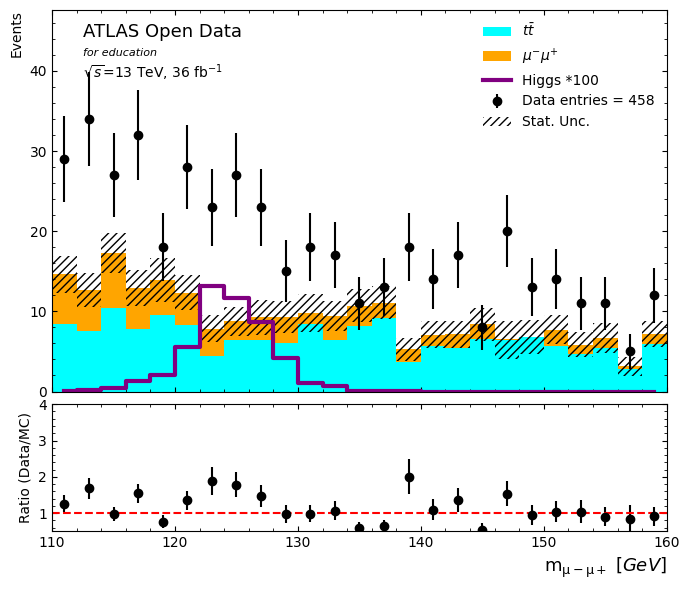

In [ ]:
plot_data(data_all,True)